# 실습 목표  

main.ipynb를 작성하여 eval dataset에 대해서 PESQ 1.35 이상 달성  


# 시작하기   
**_[Run]_** 항목은 추가 구현 없이 실행      
**_[TODO]_** 항목은 구현 하여 실행  
**_[Option]_** 항목은 필수적으로 구현할 필요는 없으나 필요시 구현  


### clean 데이터
+ [AI HUB 한국어 음성 데이터](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=123)  
2명의 화자가 특정 주제에 대해서 자유롭게 발화하는 데이터셋  

### noise 데이터
+ [CHiME4 background noises](https://spandh.dcs.shef.ac.uk/chime_challenge/CHiME4/data.html#Backgrounds)의 STR  
특정 장소(STR : 길가)에서 장시간 녹음한 잡음 데이터  


---

# Data & Code download  

## 다운받을 데이터 구성  
+ train    
    매 학습시 새로 합성하는 on-fly로 진행하기 때문에 clean, noise 파일로 구성
+ dev  
    train,eval과 겹치지 않는 데이터로 합성된 noisy 데이터  
+ eval  
    dev,eval과 겹치지 않는 데이터로 합성된 noisy 데이터
+ src :   
    사용될 코드들  

**_[Run]구글 드라이브에서 실습자료 다운로드_**     

In [1]:
!pip install pesq

from os.path import exists

if not exists("SE_dataset.tar") :
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='1hSqrUQWbwv-JmWvSbhsziA6-BwW5wFkV -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="1hSqrUQWbwv-JmWvSbhsziA6-BwW5wFkV -O SE_dataset.tar && rm -rf /tmp/cookies.txt
    !tar -xf SE_dataset.tar
else : 
    print("Dataset already downloaded.")

Dataset already downloaded.


# Init

https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

In [2]:
%load_ext autoreload
%autoreload 2

**_[RUN] 모듈 불러오기_**

In [3]:
import torch
import torch.nn as nn
from src.dataset import DatasetMix,DatasetFix
from src.UNet import UNet
from src.utils import get_output_wav,train,infer,plot_spec,eval 

from tqdm.auto import tqdm

import matplotlib.pyplot as plt 
import IPython.display as ipd

bottlenecks = None
residual_path=None

# Dataset 

DatasetMix :   
개별 clean wav에서 1초 길이를 샘플링, 하나의 긴 noise 파일에서 1초 길이를 샘플링 한 뒤  
SNR 0dB ~ 10dB 로 랜덤하게 합성   

DatasetFix :  
미리 합성된 오디오를 사용  

**_[RUN] Dataset 생성_**

In [4]:
dataset_train = DatasetMix("clean_train","noise_train.wav")
dataset_dev = DatasetFix("dev")
dataset_eval = DatasetFix("eval")

Dataset:: 1000 clean data from clean_train | noise : (29716608,)  
Dataset:: 100 clean data from dev
Dataset:: 100 clean data from eval


# Model Implementation

## UNet

![image.png](https://drive.google.com/uc?id=11liiywXpjgAn96o6ccDLZVO5QtCzBkBX)  

위 그림은 참고용 UNet 구조 예시이다.  
+ UNet은 Encoder를 통해 입력을 압축하고 Decoder를 통해 원래 차원으로 복원한다.     
+ 각 층에서의 Encoder 출력을 대응되는 층의 Decoder 단에서 concat되어서 Decoder의 입력으로 사용된다.   
  => Encoder의 출력의 크기는 대응 되는 Decoder 층의 이전 Decoder의 출력과 같아야한다.  
+ concat되는 데이터는 Residual path를 사용하여 레이어를 거칠 수도 있고, skip connection으로 아무런 조작없이 사용할 수도 있다.    
+ Encoder의 끝과 Decoder의 시작 사이에 bottleneck 레이어를 두기도 한다.  

### Input  

+ D. S. Williamson, Y. Wang and D. Wang, "Complex Ratio Masking for Monaural Speech Separation," in IEEE/ACM Transactions on Audio, Speech, and Language Processing, vol. 24, no. 3, pp. 483-492, March 2016, doi: 10.1109/TASLP.2015.2512042.  
![image.png](https://drive.google.com/uc?id=1jWyLRn4WqKVi7PqtFIVzf4o1kbJJ3tIE)   

noisy를 STFT 취한뒤, complex domain에서 magnitude를 입력으로 사용한다.
phase 성분은 위 그림처럼 제대로 정보를 취득하기 어렵기 때문에 본 실습에서는 사용하지 않는다.  


### Output  

magnitude의 Mask를 모델의 출력으로 사용한다. 입력의 magnitude에 생성된 마스크를 사용하여 잡음을 제거하고  
입력의 phase를 사용하여 WAV 신호로 복원한다.  


**_[TODO]Encoder,Decoder 구현_**  

## Encoder


![image.png](https://drive.google.com/uc?id=1yhiWPvBizH4dVdnHz5MZkv5XEH4xPiVq)  
Conv2d(Convolution) <-> ConvTranspose2d(Deconvolution)  

기본적인 Encoder,Decoder 모듈은 제공  
encoder,decoder list 에 같은 갯수의 Encoder,Decoder를 쌓아서 UNet을 구성  
+ 모듈 쌓기     
+ 모듈 수정  
+ 모듈의 파라매터 수정  
같은 작업을 수행    


In [5]:
class Encoder(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride, 
                 padding):
        super().__init__()
      
        self.conv = nn.Conv2d(in_channels, 
                              out_channels, 
                              kernel_size=kernel_size, 
                              stride=stride,
                              padding=padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.acti = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.acti(x)
        return x

encoders=[]

## TODO e.g) encoders.append(Encoder(in_channels,out_channles,kernel_size,stride,padding))

print(len(encoders))

3


## Decoder  

In [6]:
class Decoder(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels,
                 kernel_size, 
                 stride, 
                 output_padding,
                 padding=(0, 0)):
        super().__init__()
       
        self.transconv = nn.ConvTranspose2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size,
            stride=stride, 
            output_padding=output_padding,
            padding=padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.acti = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.transconv(x)
        x = self.norm(x)
        x = self.acti(x)
        return x
    
decoders=[]

## TODO e.g) decoders.append(Decoder(in_channels,out_channles,kernel_size,stride,output_padding))

print(len(decoders))

3


**_[Option]Residual Path, bottleneck 구현_**

## Optional

### Bottleneck

### Residual Path

## UNet

**_[RUN]모델 정상 동작 확인_**  
: 에러가 발생하지 않아야한다. 

In [7]:
model = UNet(encoders,decoders,bottlenecks = bottlenecks,res_paths = residual_path,print_shape=True)
x = torch.rand(1,1,257,126)
y = model(x)
print(y.shape)

Encoder 0 : torch.Size([1, 32, 126, 61])
Encoder 1 : torch.Size([1, 32, 61, 28])
Encoder 2 : torch.Size([1, 32, 29, 13])
bottleneck 0 : torch.Size([1, 32, 29, 13])
Decoder 0 : torch.Size([1, 32, 61, 28])
Decoder cat 0 : torch.Size([1, 64, 61, 28])
Decoder 1 : torch.Size([1, 32, 126, 61])
Decoder cat 1 : torch.Size([1, 64, 126, 61])
Decoder 2 : torch.Size([1, 1, 257, 126])
torch.Size([1, 1, 257, 126])


# mSDR(modified Signal-to-Distortion Ratio) Loss   

신호 대 왜곡비(SDR)과 비례하는 mSDR를 사용하여, 
음성 향상과 잡음 제거사이에 wegiht를 부여한 wSDR 

+ Venkataramani, Shrikant, Jonah Casebeer, and Paris Smaragdis. "Adaptive front-ends for end-to-end source separation." Proc. NIPS. 2017.  
+ Choi, Hyeong-Seok, et al. "Phase-aware speech enhancement with deep complex u-net." International Conference on Learning Representations. 2018.  

![image.png](https://drive.google.com/uc?id=1bis4FlepY8H9TULmapLEX7XU9QcL5Iqi)  


**_[TODO]mSDRLoss 구현_**     
:  식 (6) 구현    
mSDR만 사용하면 (alpha = 1.0 일 때) 잡음에 대한 고려를 하지 않기 때문에 잡음제거가 거의 이루어지지 않는다.   
모델에 목적에 맞추서 alpha를 잘 설정하는 것이 중요하다.  


In [8]:
"""
    x     : noisy = y+z
    y     : clean
    y_hat : estimated clean 
    z     : noise
    z     : estimated noise
"""

def mSDRLoss(y,y_hat, eps=1e-7):
    ## TODO mSDRLoss 구현

    return mSDR

def wSDRLoss(y_hat,x,y,alpha=0.99,eps=2e-7):
        z = x - y
        z_hat = x - y_hat

        wSDR = alpha * mSDRLoss(y,y_hat,eps=eps) + (1-alpha)*mSDRLoss(z,z_hat,eps=eps)
        return wSDR
    

# Train

**_[TODO]학습 진행_**

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

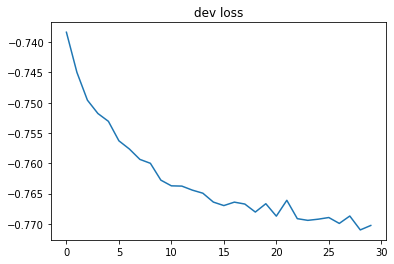

In [9]:
model = UNet(encoders,decoders,bottlenecks = bottlenecks,res_paths = residual_path,print_shape=False)
train(model,dataset_train,dataset_dev,wSDRLoss)

## Visualization  
**_[Run]모델 출력 시각화_**

+ clean

+ noisy

+ estim

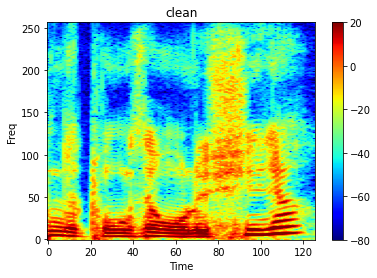

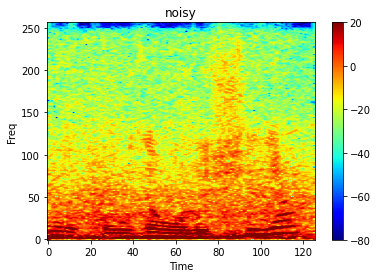

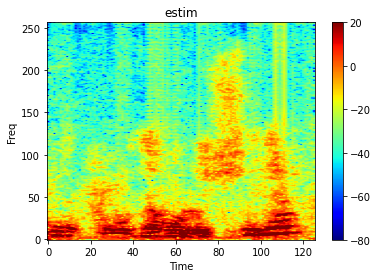

In [10]:
# Data to visualize
idx = 0

model.eval()
with torch.no_grad():
    clean,noisy,estim = infer(dataset_eval[idx],model)
    
    ipd.display(ipd.Markdown('+ clean'))
    display(ipd.Audio(clean,rate=16000))
    
    plot_spec(clean,"clean")
    plot_spec(noisy,"noisy")
    plot_spec(estim,"estim")
    
    ipd.display(ipd.Markdown('+ noisy'))
    display(ipd.Audio(noisy,rate=16000))
    
    ipd.display(ipd.Markdown('+ estim'))
    display(ipd.Audio(estim,rate=16000))

# Evaluation

+ PESQ(Perceptual Evaluation of Speech Quality)
통신에서 통화품질 성능 지표로 사용되었으며,    
음성 인식 성능과 상관관계가 있기 때문에 음성 향상 성능 지표로 자주 사용한다.  

**_[Run] PESQ 확인 : 1.35 이상 달성_**

In [11]:
eval(dataset_eval,model)

  0%|          | 0/100 [00:00<?, ?it/s]

PESQ : 1.2264378588609022 -> 1.3548738751748595
